# Classifying vowels in Nomlaki

## Description of data
Anna's copy of the Nomlaki notebook. Based (heavily) on work at https://github.com/emilyremirez/ExemPy.

In [1]:
# Set up
%load_ext autoreload
import GCMPykj as gp
%aimport GCMPykj
%autoreload 1
import math
import random
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns

sns.set(style='ticks', context='paper')
colors=["#045447","#A6262E","#FFBB00","#253060","#8EAB27","#36B5AA"]
sns.set_palette(colors)

## Read in data

In [2]:
#read in file containing all nom vowels, including with and without official spellings
nom_raw = pd.read_csv("nomlaki-vowels.csv")

#rename cols
nom_raw.rename(columns = {'raw_phoneme':'vowel', 'phoneme':'spelling'}, inplace = True)

#remove entries with non-vowels
list_vowels = ['a','e','i','o','u']
nom_vowels = nom_raw[nom_raw['vowel'].isin(list_vowels)]

#nomlaki is df without spellings, n = 2138
nomlaki = nom_vowels.drop(['time','word','spelling'],axis=1)

# #nom_spell is subset containing spellings, n = 316. Use nom_spell to classify based 
# #on Nomlaki textbook spelling instead of IPA classification.

# nom_spell = nom_vowels.drop(['time','word','vowel'],axis=1)
# nom_spell = nom_spell.dropna(subset=['spelling'])


In [3]:
#assigning examplars to nomlaki

exemplars = nomlaki

#if doing spelling, set to exemplars = nom_spell

## Optimize

Define a function to calculate the proportion of error

In [4]:
def calcerror(x,test,exemplars,catslist,fitdims,cval,anchordim=None):
    '''
    Categorizes a data set and returns the proportion of stimuli/test rows
    that were categorized inaccurately. A lower value means a lower amount of
    error. Designed to be used with parameter fitting functions to assign
    values to attention weighting for the dimensions.
    
    Required parameters:
    
    x = Array. Initial guesses for parameters
    
    test = DataFrame. Stimuli to be categorized
    
    exemplars = DataFrame. Exemplar cloud to use for categorization
    
    catslist = List of strings. Each string should correspond to a category that
        should be assigned to the test
    
    fitdims = List of strings. Each string should correspond to a dimension
        for which parameters should be fit.
        
    Optional parameters:
    
    anchordim = String. Dimension for parameter which will not be fit, but will
        instead be hard-coded as 1. This helps constrain the set of possible
        solutions
    
    
    '''
    #x = [z1,z2,z3]
    # dimslist = [z0, z1, z2, z3]
    # dimsdict = {z0 =1, z1 = z1guess, z2 = z2guess, z3=z3guess}
    # dimslist[0] = z0        dl[1] = z1,       dl[2] = z2.      dl[3] = z3
    #            1            x[0]= z1,          x[1] = z2,      x[2] =z3 

    
    dimsvals = {fitdims[i]: x[i] for i in range(len(fitdims))}
    if anchordim != None:
        dimsvals.update({anchordim:1})
    
    choices=gp.multicat(test,cloud,catslist,dimsvals,cval)
    accuracy=gp.checkaccuracy(choices,catslist)
    category=catslist[0]
    err = accuracy[category+"Acc"].value_counts(normalize=True)['n']
    return err

# Set initial parameters for categorization


In [5]:
cval=25
dimsvals={'F1' : .761,
          'F2' : .681,
          'F3' : .407,
          'duration':1}
dimslist=list(dimsvals.keys())
catslist=['vowel']
test=gp.gettestset(exemplars,'vowel',2)          # get a testset with 2 examples each phoneme; 
                                                 # if using spelling set 2nd argument to 'spelling'
cloud = exemplars

In [12]:
fitdims = dimslist[1:]      # Fit all dimensions except item 0
anchordim = dimslist[0]     # Set item 0 to 1

name = 'nom_vowel_optimization'   # name of output spreadsheet
n = 3                        # number of times that random x is generated
#-------------------------------------------

resultslist=[['start','fit','error','evals']] # initialize a list for results 

print("----- Parameters -----")
if anchordim != None: 
    print("Anchored (1):  ", anchordim)
    
print("Optimized:     ", fitdims)
print("")
print("Trials: ",n)
print("")

for i in range(0,n): 
    x=np.divide(random.sample(range(0,300),len(fitdims)),100)
        # Get a random sample of numbers between 0 and 300,
           # divide by 100 to get floats between 0 and 3  
    xguess = x
    result = minimize(calcerror,
                  xguess,  # the initial guess array
                  args=(test,cloud,catslist,fitdims,cval,anchordim), # arguments for the error function
                  method='Powell',  
                  tol=0.05,  # a 'tolerance' value, smaller means more function evaluation, but potentially better fit
                 )
    start = x
    fit = np.round(result.x,3)
    error = result.fun
    evals = result.nfev
    row = [start,fit,error,evals]
    resultslist.append(row)
    
    print ("-----", (i+1) ," -----")
    print("Initial guess:    ", start)
    print("Optimized:        ", fit)
    print(" ")
    print("Number evals: ", evals)
    print("Error:        ", error)
    print("")
results=pd.DataFrame(resultslist)
results.columns = results.iloc[0]
results=results[1:]

# Save the (last set of) fitted parameters in a dimsvals dict
### with keys dimensions, values as attention weights
squeebo = {fitdims[i]: result.x[i] for i in range(len(fitdims))}
squeebo.update({anchordim:1})

# write results to csv
## good for if you want to leave it running while you do something else!
results.to_csv(name+".csv")     

----- Parameters -----
Anchored (1):   F1
Optimized:      ['F2', 'F3', 'duration']

Trials:  3

----- 1  -----
Initial guess:     [2.48 1.28 2.64]
Optimized:         [5.48  5.28  1.786]
 
Number evals:  31
Error:         0.1

----- 2  -----
Initial guess:     [0.62 2.33 2.76]
Optimized:         [1.62 3.33 3.76]
 
Number evals:  13
Error:         0.2

----- 3  -----
Initial guess:     [1.84 0.39 2.85]
Optimized:         [2.84 1.39 3.85]
 
Number evals:  13
Error:         0.2



In [19]:
to_cat = gp.gettestset(exemplars,'vowel',25) #if using spelling set 2nd arg to 'spelling'

# Categorize all exemplars wrt other exemplars

In [20]:
choices=gp.multicat(
    to_cat,       # what to categorize
    cloud,       # exemplar cloud
    catslist,        # categories to categorize on
    dimsvals,         # dictionary with keys as dimensions and values as attention weights
    cval,            # sensitivity value--a pain in the ass. I just keep it at 25 bc i fit that once
    exclude_self=True,  # Don't compare exemplars to themselves
    N=1,             # give everything a resting activation of 1
    runnerup=False   # Don't give us the second choice category
    )

## Get confusion matrix

In [21]:
gp.confusion(choices,'vowel')['vowel'] #if using spelling replace 'vowel' with 'spelling'

vowelChoice,a,e,i,o,u
a,0.88,0.04,0.00,0.04,0.04
e,0.04,0.80,0.16,0.00,0.00
i,0.00,0.08,0.92,0.00,0.00
o,0.08,0.00,0.00,0.80,0.12
u,0.16,0.04,0.00,0.20,0.60


# Check accuracy
 - check the accuracy of the categorization, get df with y or n for each cat
 - plot accuracy by category as bar graph
 - get proportion overall correct
 - get proportions by category

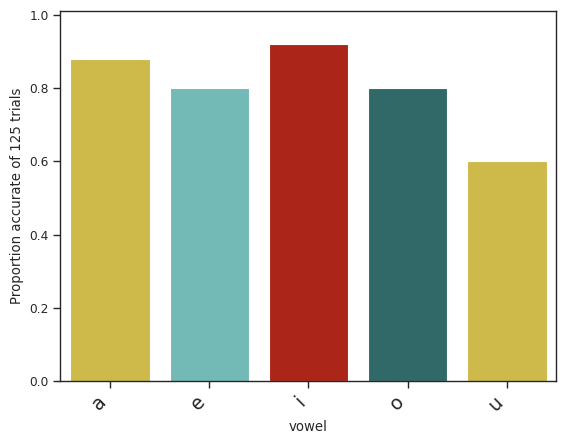

<AxesSubplot:xlabel='vowel', ylabel='Proportion accurate of 125 trials'>

In [22]:
acc = gp.checkaccuracy(choices,["vowel"]) #if using spelling replace 'vowel' with 'spelling'
gp.accplot(acc,'vowel')

In [23]:
print("overall accuracy: " + str(gp.overallacc(acc,'vowel'))) #if using spelling replace with 'spelling'
gp.propcorr(acc,'vowel')

overall accuracy: 0.8


,vowel,propcorr
0,a,0.88
1,e,0.80
2,i,0.92
3,o,0.80
4,u,0.60


In [24]:
# get the subset of data that was categorized inaccurately
inaccuratephons = acc.loc[acc['vowelAcc']=="n"].reset_index() #if using spelling set to 'spellAcc'
inaccuratephons

,index,vowel,F1,F2,F3,duration,vowelChoice,vowelProb,vowelAcc
0,0,e,313.590363,1869.944327,2429.185545,0.173439,i,1.000000,n
1,2,e,449.468086,1386.194078,2363.682455,0.080343,a,1.000000,n
2,4,e,319.049452,1984.050623,2350.093493,0.188743,i,1.000000,n
3,18,e,375.496209,1882.880116,2335.301039,0.147933,i,1.000000,n
4,19,e,328.061846,1594.632795,1717.668661,0.063764,i,1.000000,n
5,28,a,419.329403,1232.626477,2471.621230,0.073170,u,1.000000,n
6,39,a,344.240526,1291.412999,2480.746331,0.043041,e,0.999617,n
7,43,a,507.768958,1113.361903,2586.009742,0.117326,o,1.000000,n
8,51,i,224.839822,1964.404452,2326.937947,0.184528,e,0.999979,n
9,56,i,367.144477,1865.496245,2314.136881,0.083874,e,1.000000,n
